# Imports

In [1]:
import torch
import pytorch_lightning as pl
import tensorboard as tb
import json
import time
import warnings
from torch import nn
from pytorch_lightning.accelerators import *
from torch.utils.tensorboard import SummaryWriter
from lightning.pytorch.accelerators import find_usable_cuda_devices
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, DeviceStatsMonitor
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataloading_helpers import electricity_dataloader
from config import *

# EDA

In the following we will take a short look into the electricity dataset.
To not create bias, we will just look at the train dataset.
Because the dataset is not too complex, we will mostly look at the distribution of the target value.

In [2]:
train, _, _ = electricity_dataloader.create_electricity_dataframe_not_normalized()  
train.info()

In [16]:
train.head()

,power_usage,time_idx,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,2.538071,26304,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1,26304.0,2,0
17545,2.855330,26305,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1,26305.0,2,1
17546,2.855330,26306,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1,26306.0,2,2
17547,2.855330,26307,1096,MT_001,2014-01-01 03:00:00,MT_001,3,1,2,1,26307.0,2,3
17548,2.538071,26308,1096,MT_001,2014-01-01 04:00:00,MT_001,4,1,2,1,26308.0,2,4


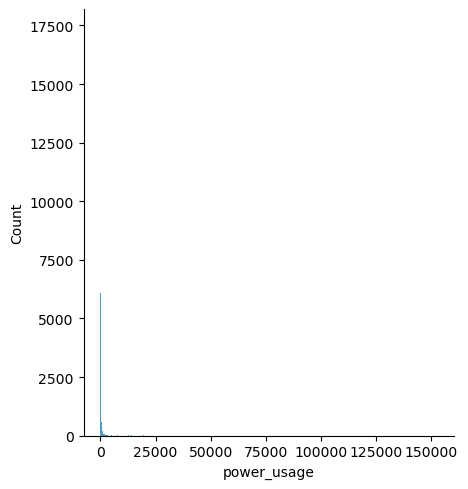

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

visual = sns.displot(data=train, x="power_usage", discrete=True)
plt.show()

In [ ]:
import matplotlib
matplotlib.pyplot.scatter(x, y, 
s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, 
vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)

In [25]:
sns.scatterplot(train, y="power_usage")

ValueError: Could not interpret value `power_usage` for parameter `y`

In [ ]:
train["categorical_id"].unique().sum()

In [ ]:
train.groupby(["categorical_id"]).mean("power_usage")

# Evaluating TFT model on electricity dataset
After we have run the hyperparameter optimization script and done a full training run with the TFT and the electricity dataset, we can load the model with the lowest validaiton loss into this notebook and have a closer look into our performance and explainability. We have to instantiate the trainer and model, before loading the training state.

In [ ]:
# best parameters estimated by hypertuning and manually rounded
hyper_dict = {
               'gradient_clip_val': 0.052, 
                'hidden_size': 128, 
                'dropout': 0.15, 
                'hidden_continuous_size': 32, 
                'attention_head_size': 2, 
                'learning_rate': 0.007,
               }
  
  # uncomment to read hyperparamters from hyper-tuning script
  #hyper_dict = pd.read_pickle(CONFIG_DICT["models"]["electricity"] / "tuning_logs" / "hypertuning_electricity.pkl")
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=CONFIG_DICT["models"]["electricity"] / "checkpoint_callback_logs",
    filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger(CONFIG_DICT["models"]["electricity"])  # logging results to a tensorboard


trainer = pl.Trainer(
    default_root_dir=CONFIG_DICT["models"]["electricity"],
    max_epochs=2,
    accelerator=accelerator,
    devices=devices,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=20, 
    fast_dev_run=False,  
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    log_every_n_steps=1,
    logger=logger,
    profiler="simple",
    )

tft = TemporalFusionTransformer.from_dataset(
    electricity["training_dataset"],
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size= 3,  
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    log_interval=1,
    reduce_on_plateau_patience=2,
    optimizer="adam"
    )

tft.load_state_dict(torch.load(CONFIG_DICT["models"]["electricity"] / "tft_model"))
output = trainer.test(model=tft, dataloaders=electricity["test_dataloader"], ckpt_path="best")
